# Preparation

In [1]:
# Import function libraries first
import numpy as np
import pandas as pd
import os

# Show the available data inputs
print(os.listdir('../input'))

['new-york-city-taxi-fare-prediction']


# Load the data

In [4]:
# Make predictions on the train set
train_df = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/train.csv', nrows=10_000_000)

In [5]:
# Show the data types of the train set
train_df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [6]:
# Show first five rows of the train set
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [7]:
# Show latter five rows of the training dataset
train_df.tail()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
9999995,2012-08-12 01:18:00.000000208,5.7,2012-08-12 01:18:00 UTC,-73.999464,40.728452,-73.993299,40.742100,2
9999996,2013-08-07 10:28:00.000000147,5.5,2013-08-07 10:28:00 UTC,-73.968467,40.759367,-73.964967,40.769027,1
9999997,2013-10-29 08:29:00.00000082,14.0,2013-10-29 08:29:00 UTC,-73.997952,40.733717,-73.973448,40.759122,5
9999998,2012-04-07 16:41:33.0000004,10.5,2012-04-07 16:41:33 UTC,-73.992700,40.752021,-73.964705,40.772849,1
9999999,2010-03-30 19:27:00.00000066,8.5,2010-03-30 19:27:00 UTC,-73.965390,40.768572,-73.998188,40.761073,1


In [8]:
# Given a dataframe, add two new features: 'abs_diff_longitude' and 'abs_diff_latitude' representing the "Manhattan vector" from the pickup location to the dropoff location
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train_df)

# Analyze missing values

In [9]:
# Explore and prune outliers
print(train_df.isnull().sum())

key                    0
fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude     69
dropoff_latitude      69
passenger_count        0
abs_diff_longitude    69
abs_diff_latitude     69
dtype: int64


In [10]:
# Remove unrelated data feature from the dataset
print('Old size: %d' % len(train_df))
train_df = train_df.dropna(how='any', axis='rows')
print('New size: %d' % len(train_df))

Old size: 10000000
New size: 9999931


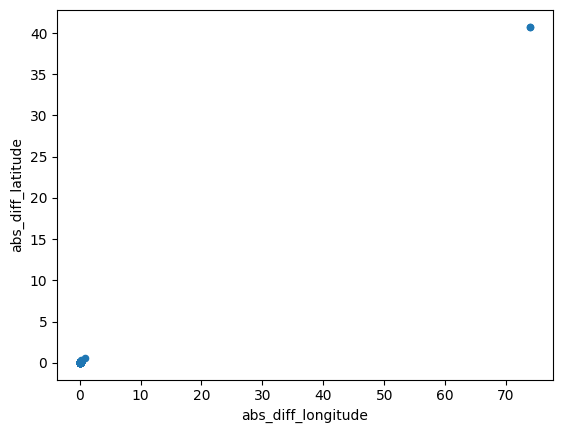

In [11]:
# Generate plot function
plot = train_df.iloc[:2000].plot.scatter('abs_diff_longitude', 'abs_diff_latitude')

In [12]:
# Update the cumulative values of each data feature
print('Old size (updated): %d' % len(train_df))
train_df = train_df[(train_df.abs_diff_longitude < 5.0) & (train_df.abs_diff_latitude < 5.0)]
print('New size (updated): %d' % len(train_df))

Old size (updated): 9999931
New size (updated): 9979187


# Model training

In [13]:
# Construct and return an Nx3 input matrix for this linear model using the travel vector, along with a value of 1.0 for a constant bias term
def get_input_matrix(df):
    return np.column_stack((df.abs_diff_longitude, df.abs_diff_latitude, np.ones(len(df))))

train_X = get_input_matrix(train_df)
train_y = np.array(train_df['fare_amount'])

print(train_X.shape)
print(train_y.shape)

(9979187, 3)
(9979187,)


In [14]:
# Use NumPy's lstsq library function to find the optimal weight column
(w, _, _, _) = np.linalg.lstsq(train_X, train_y, rcond=None)

print(w)

[147.16176525  76.95503724   6.39545245]


In [15]:
# Ordinary least squares (OLS) method
w_OLS = np.matmul(np.matmul(np.linalg.inv(np.matmul(train_X.T, train_X)), train_X.T), train_y)

print(w_OLS)

[147.16176525  76.95503724   6.39545245]


# Weight-based prediction

In [16]:
# Make predictions on the test set
test_df = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/test.csv')

In [17]:
# Show the data types of the test set
test_df.dtypes

key                   object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [18]:
# Show first five rows of the test set
test_df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [19]:
# Show latter five rows of the test set
test_df.tail()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51 UTC,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51 UTC,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15 UTC,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19 UTC,-73.985573,40.735432,-73.939178,40.801731,6
9913,2015-01-18 14:06:23.0000006,2015-01-18 14:06:23 UTC,-73.988022,40.754070,-74.000282,40.759220,6


In [21]:
# Reuse the defined helper functions to add features and generate the input matrix
add_travel_vector_features(test_df)
test_X = get_input_matrix(test_df)

# Predict fare_amount on the test set using the weight model trained on the train set
test_y_predictions = np.matmul(test_X, w).round(decimals=2)
test_y_predictions

array([ 9.13,  9.69,  7.21, ..., 42.23, 18.33,  8.6 ])

# Generate submission

In [22]:
# Write the predictions to a comma-separated values (CSV) file which can be submitted to the competition
submission = pd.DataFrame(
    {'key': test_df.key, 'fare_amount': test_y_predictions},
    columns = ['key', 'fare_amount']
)
submission.to_csv('submission.csv', index=False)

print(os.listdir('.'))
print("Successfully saved as CSV file")

['submission.csv', '.virtual_documents']
Successfully saved as CSV file
